## Business Understanding

Perusahaan lending menghadapi tantangan utama berupa risiko kredit,
yaitu kemungkinan peminjam gagal melunasi pinjaman tepat waktu.
Risiko ini dapat menyebabkan kerugian finansial yang signifikan.

Tujuan dari proyek ini adalah membangun model machine learning
yang mampu memprediksi credit risk berdasarkan karakteristik peminjam,
sehingga dapat membantu perusahaan dalam proses pengambilan keputusan
persetujuan pinjaman secara lebih objektif dan terukur.


# Import Library

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, recall_score, precision_score

# Load Data
try:
  df = pd.read_csv("loan_data_2007_2014.csv")
  print("Data Loaded Successfully!")
  print(f"Shape: {df.shape}")
except FileNotFoundError:
  print("Error: File 'loan_data_2007_2014.csv' tidak ditemukan. Pastikan file ada di folder yang sama.")

/tmp/ipython-input-1593530654.py:15: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan_data_2007_2014.csv")


Data Loaded Successfully!
Shape: (273917, 75)


# Data Understanding

In [31]:
df = pd.read_csv("loan_data_2007_2014.csv")
df.shape
df.info()
df['loan_status'].value_counts()

/tmp/ipython-input-3177619564.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan_data_2007_2014.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273917 entries, 0 to 273916
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   273917 non-null  int64  
 1   id                           273917 non-null  int64  
 2   member_id                    273917 non-null  int64  
 3   loan_amnt                    273917 non-null  int64  
 4   funded_amnt                  273917 non-null  int64  
 5   funded_amnt_inv              273917 non-null  float64
 6   term                         273917 non-null  object 
 7   int_rate                     273917 non-null  float64
 8   installment                  273917 non-null  float64
 9   grade                        273917 non-null  object 
 10  sub_grade                    273917 non-null  object 
 11  emp_title                    257265 non-null  object 
 12  emp_length                   262631 non-null  object 
 13 

,count
loan_status,
Fully Paid,136973
Current,98900
Charged Off,29957
Late (31-120 days),3004
Does not meet the credit policy. Status:Fully Paid,1988
In Grace Period,1489
Does not meet the credit policy. Status:Charged Off,761
Late (16-30 days),515
Default,329


# Preprocessing & Cleaning

In [32]:
# 1. Filter Target Variable
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])].copy()

# 2. Encoding Target (0 = Good, 1 = Bad)
df['target'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

# 3. Select Features
features = ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'dti', 'emp_length']
X = df[features].copy()
y = df['target']

# 4. Feature Engineering (Cleaning text -> number)
# Menggunakan r'' (raw string) agar tidak muncul SyntaxWarning
X['term'] = X['term'].astype(str).str.extract(r'(\d+)').astype(float)
X['emp_length'] = X['emp_length'].astype(str).str.extract(r'(\d+)').astype(float)

# 5. Handling Missing Values (Imputasi)
# Kita isi nilai kosong dengan Median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)

print("Preprocessing Complete!")
print(f"Missing values after imputation:\n{X_imputed.isnull().sum()}")

Preprocessing Complete!
Missing values after imputation:
loan_amnt     0
term          0
int_rate      0
annual_inc    0
dti           0
emp_length    0
dtype: int64


# Training Model

In [33]:
# 1. Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y)

# 2. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Model Training
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

print("Model Training Complete!")

Model Training Complete!


# Evaluasi & Threshold Tuning

ROC-AUC Score: 0.66

--- Evaluasi dengan Threshold 0.2 ---
              precision    recall  f1-score   support

           0       0.87      0.67      0.76     27395
           1       0.27      0.55      0.36      5991

    accuracy                           0.65     33386
   macro avg       0.57      0.61      0.56     33386
weighted avg       0.77      0.65      0.69     33386



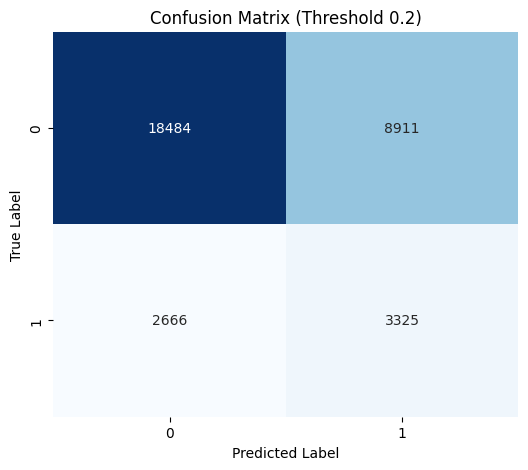

Recall (Bad Loan): 0.55
Insight: Recall sudah cukup baik. Siap untuk dipresentasikan.


In [34]:
# Prediksi Probabilitas
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Cek ROC-AUC
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.2f}")

# --- THRESHOLD TUNING ---
custom_threshold = 0.2  # Coba ubah angka ini jika ingin hasil berbeda (0.3 - 0.5)

y_pred_adj = (y_prob >= custom_threshold).astype(int)

print(f"\n--- Evaluasi dengan Threshold {custom_threshold} ---")
print(classification_report(y_test, y_pred_adj))

# Visualisasi Confusion Matrix (Screenshot bagian ini untuk PPT)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_adj)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix (Threshold {custom_threshold})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Insight Singkat
rec = recall_score(y_test, y_pred_adj)
print(f"Recall (Bad Loan): {rec:.2f}")
if rec < 0.5:
    print("Insight: Recall masih rendah. Coba turunkan 'custom_threshold' menjadi 0.3")
else:
    print("Insight: Recall sudah cukup baik. Siap untuk dipresentasikan.")

# Feature Importance

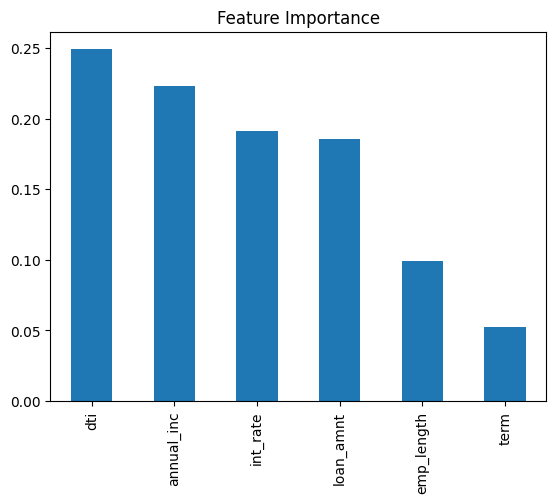

In [35]:
importance = pd.Series(rf.feature_importances_,index=X.columns).sort_values(ascending=False)
importance.plot(kind='bar')
plt.title("Feature Importance")
plt.show()

# Save Model

In [36]:
# Simpan Model dan Scaler
joblib.dump(model, 'credit_risk_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("End-to-End Process Selesai!")
print("File 'credit_risk_model.pkl' dan 'scaler.pkl' berhasil disimpan.")

End-to-End Process Selesai!
File 'credit_risk_model.pkl' dan 'scaler.pkl' berhasil disimpan.
